In [1]:
import warnings
warnings.simplefilter('ignore', (FutureWarning, DeprecationWarning))

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['savefig.dpi']=300
plt.rcParams['savefig.bbox'] ='tight'
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
pd.set_option('precision', 3)
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

In [10]:
from sklearn.datasets import fetch_openml
data = fetch_openml('mammography')
X, y = data.data, data.target
y= (y.astype(np.int) + 1) // 2

In [12]:
X.shape

(11183, 6)

In [13]:
np.bincount(y)

array([10923,   260], dtype=int64)

In [40]:
df = pd.DataFrame(X)
df_y = pd.DataFrame(y)
df2 = df.copy()
#df.drop(['target'], axis=1)
df2['target'] = df_y

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000246533D0AC8>,
      dtype=object)

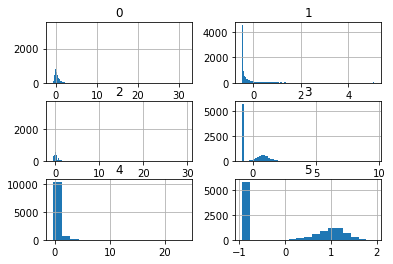

In [16]:
df.hist(bins = 'auto')

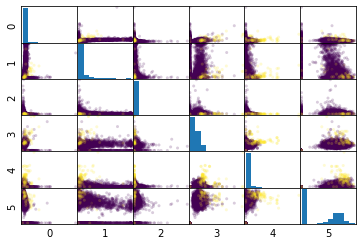

In [17]:
axes =  pd.plotting.scatter_matrix(df, c=y, alpha =.2);
for ax in axes.ravel():
    ax.set_xticks(())
    ax.set_yticks(())


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

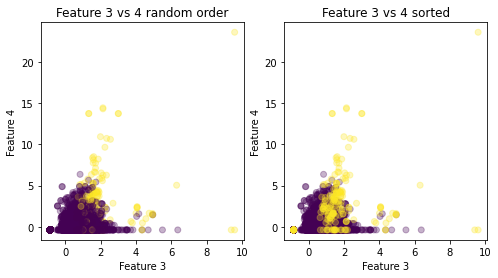

In [19]:
sorting = np.argsort(y_train)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(X_train[:, 3], X_train[:, 4], c=y_train[:], alpha=.3)
axes[1].scatter(X_train[sorting, 3], X_train[sorting, 4], c=y_train[sorting], alpha=.3)
axes[0].set_title("Feature 3 vs 4 random order")
axes[1].set_title("Feature 3 vs 4 sorted")
for ax in axes:
    ax.set_xlabel("Feature 3")
    ax.set_ylabel("Feature 4")

In [20]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

In [21]:
scores = cross_validate(LogisticRegression(), X_train, y_train,
                       cv = 10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9202523350276881, 0.6335760292641773)

# Visualization of the data using seaborn

In [22]:
import seaborn as sns

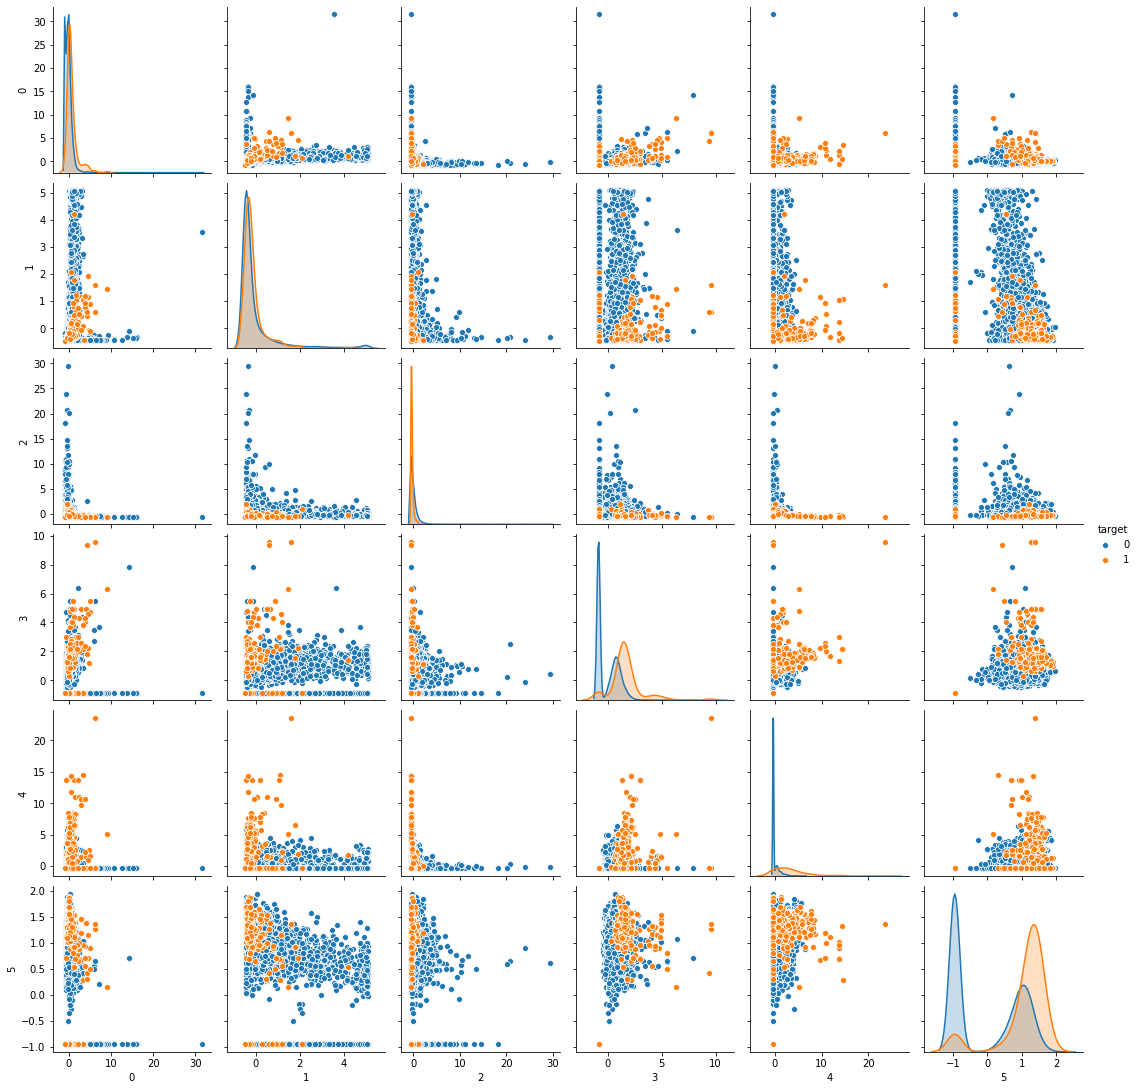

In [41]:
sns.pairplot(df2, hue='target' )

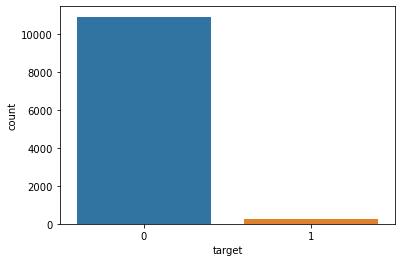

In [42]:
sns.countplot(df2['target'])

# USING UNDER-SAMPLING AND OVER-SAMPLING TO BALANCE THE DATA

# Imbalanced-Learn


# UnderSampling

In [48]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_sample(X_train,y_train)
print(X_train.shape)
print(X_train_subsample.shape)
print('Original target',np.bincount(y_train))
print('Subsampled target', np.bincount(y_train_subsample))

(8387, 6)
(390, 6)
Original target [8192  195]
Subsampled target [195 195]


In [52]:
print('Original Scores: (0.9202523350276881, 0.6335760292641773)')
from imblearn.pipeline import make_pipeline as make_imb_pipeline

undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LogisticRegression())
scores = cross_validate(undersample_pipe,
                    X_train, y_train, cv =10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()


Original Scores: (0.9202523350276881, 0.6335760292641773)


(0.916293375715712, 0.5388223508031831)

# oversampling
More like stepping up the smaller data to balance the second targets

In [53]:
from imblearn.over_sampling import RandomOverSampler

ros =RandomOverSampler()
X_train_oversample, y_train_oversample = ros.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_oversample.shape)
print('Original:', np.bincount(y_train))
print('OverSample ',np.bincount(y_train_oversample))

(8387, 6)
(16384, 6)
Original: [8192  195]
OverSample  [8192 8192]


In [55]:
# Checking the scores with oversampling and the original scores

print('Original Scores: (0.9202523350276881, 0.6335760292641773)')
oversample_pipe = make_imb_pipeline(RandomOverSampler(), LogisticRegression())
scores =  cross_validate(oversample_pipe,
                        X_train, y_train, cv =10, scoring=('roc_auc', 'average_precision' ))

scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

Original Scores: (0.9202523350276881, 0.6335760292641773)


(0.915968760237053, 0.5870695240262193)

# Visualization of roc_curve and precision_recall_curve

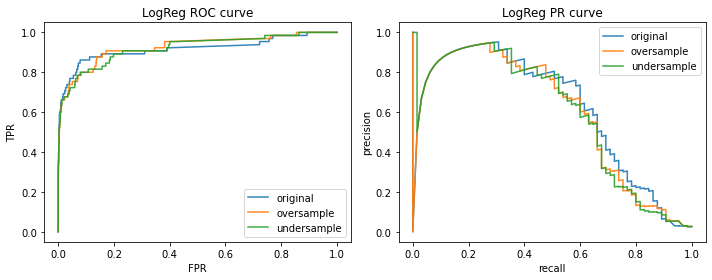

In [57]:
from sklearn.metrics import roc_curve, precision_recall_curve
oversample_pipe.fit(X_train, y_train)
probs_oversample = oversample_pipe.predict_proba(X_test)[:, 1]
fpr_over, tpr_over, _ = roc_curve(y_test, probs_oversample)
precision_over, recall_over, _ = precision_recall_curve(y_test, probs_oversample)

undersample_pipe.fit(X_train, y_train)
probs_undersample = undersample_pipe.predict_proba(X_test)[:, 1]
fpr_under, tpr_under, _ = roc_curve(y_test, probs_undersample)
precision_under, recall_under, _ = precision_recall_curve(y_test, probs_undersample)

lr = LogisticRegression().fit(X_train, y_train)
probs_original = lr.predict_proba(X_test)[:, 1]
fpr_org, tpr_org, _ = roc_curve(y_test, probs_original)
precision_org, recall_org, _ = precision_recall_curve(y_test, probs_original)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(fpr_org, tpr_org, label="original", alpha=.9)
axes[0].plot(fpr_over, tpr_over, label="oversample", alpha=.9)
axes[0].plot(fpr_under, tpr_under, label="undersample", alpha=.9)
axes[0].legend()
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("LogReg ROC curve")

axes[1].plot(recall_org, precision_org, label="original", alpha=.9)
axes[1].plot(recall_over, precision_over, label="oversample", alpha=.9)
axes[1].plot(recall_under, precision_under, label="undersample", alpha=.9)
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("LogReg PR curve")
plt.tight_layout()

# Imbalance data with Random Forest

In [62]:
from sklearn.ensemble import RandomForestClassifier
scores = cross_validate(RandomForestClassifier(), X_train, y_train,
                       cv = 10, scoring =['roc_auc', 'average_precision'])
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9447969987507856, 0.7384105387776583)

# undersampling with rf

In [69]:
print('normal score is (0.9447969987507856, 0.7384105387776583)')

undersample_pipe_rf = make_imb_pipeline(RandomUnderSampler(), RandomForestClassifier())

scores = cross_validate(undersample_pipe_rf, X_train, y_train,
                       cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

normal score is (0.9447969987507856, 0.7384105387776583)


(0.9494356004144194, 0.6185303393243803)

# Oversampling with rf

In [70]:
print('normal score is (0.9447969987507856, 0.7384105387776583)')

oversample_pipe_rf = make_imb_pipeline(RandomOverSampler(), RandomForestClassifier(n_estimators=100))
scores = cross_validate(oversample_pipe_rf,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()


normal score is (0.9447969987507856, 0.7384105387776583)


(0.9264589867414001, 0.7148688418060976)